<a href="https://colab.research.google.com/github/SUTFutureCoder/LookForJayChou/blob/master/LookForJayChou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LookForJayChou
寻找周杰伦

用于练习图像检索会很有意思的样子

十年前我也是饭圈男孩！

┭⑩哖騚珴也遈飯圈楠孓亥！_/~↘

有那味了，开搞

# Copyright
北京航空航天大学 ZF1921335
https://github.com/SUTFutureCoder/LookForJayChou


# 数据集来源
数据集来源于[十个明星的面部数据集](https://aistudio.baidu.com/aistudio/datasetDetail/13959)

# Let's roll

### 第一步直接从Google硬盘解压数据集

In [0]:
!unzip /content/drive/My\ Drive/AIColab/LookForJayChou/images.zip

Archive:  /content/drive/My Drive/AIColab/LookForJayChou/images.zip
   creating: images/
   creating: images/face/
   creating: images/face/fanbingbing/
  inflating: images/face/fanbingbing/1.png  
  inflating: images/face/fanbingbing/10.png  
  inflating: images/face/fanbingbing/101.png  
  inflating: images/face/fanbingbing/102.png  
  inflating: images/face/fanbingbing/103.png  
  inflating: images/face/fanbingbing/104.png  
  inflating: images/face/fanbingbing/105.png  
  inflating: images/face/fanbingbing/106.png  
  inflating: images/face/fanbingbing/108.png  
  inflating: images/face/fanbingbing/109.png  
  inflating: images/face/fanbingbing/11.png  
  inflating: images/face/fanbingbing/110.png  
  inflating: images/face/fanbingbing/111.png  
  inflating: images/face/fanbingbing/112.png  
  inflating: images/face/fanbingbing/114.png  
  inflating: images/face/fanbingbing/115.png  
  inflating: images/face/fanbingbing/118.png  
  inflating: images/face/fanbingbing/119.png  
  inf

### 开写

In [0]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import copy

### 预定义超参数

In [0]:
IMG_SIZE = 256
INPUT_SIZE = 224
BATCH_SIZE = 256
EPOCHS_SIZE = 32
BASE_LR = 0.01
CLASSFIERS = 10
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if CUDA else 'cpu')

### 预定义图像变换

In [0]:
transform = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

### 读入图片

In [0]:
class DataSet(data.Dataset):
  def __init__(self, dataset, transform):
    self.dataset = dataset
    self.transform = transform

  def __getitem__(self, index):
    return self.transform(self.dataset[index][0]), self.dataset[index][1]

  def __len__(self):
    return len(self.dataset)

In [0]:
data_dir = "./images/face"


image_datasets = datasets.ImageFolder(data_dir)

train_size = int(len(image_datasets) * 0.8)
val_size = len(image_datasets) - train_size

train_subdataset, val_subdataset = data.random_split(image_datasets, [train_size, val_size])

splited_datasets = {}
splited_datasets['train'] = DataSet(train_subdataset, transform['train'])
splited_datasets['val'] = DataSet(val_subdataset, transform['val'])

dataloaders = {x: torch.utils.data.DataLoader(splited_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']}

### 定义模型

In [0]:
def ResNet152(classfiers):
  model = torchvision.models.resnet152(pretrained=True)

  # freeze
  for param in model.parameters():
    param.requires_grad = False
  
  # 放开最后一层
  for param in model.layer4.parameters():
    param.requires_grad = True

  model.fc = nn.Linear(model.fc.in_features, classfiers)
  model.to(DEVICE)
  return model

### 定义训练函数

In [0]:
def train(model, dataloader, optimizer, criterion):
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(EPOCHS_SIZE):
    print("EPOCH {}/{}".format(epoch, EPOCHS_SIZE - 1))
    print("-" * 10)

    optim.lr_scheduler.StepLR(optimizer, 15, 0.01)
    
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_correct = 0
      
      for x, y in dataloader[phase]:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          out = model(x)
          loss = criterion(out, y)

        _, pred = torch.max(out, 1)



        if phase == 'train':
          loss.backward()
          optimizer.step()

        running_loss += loss.item() / x.size(0)
        running_correct += torch.sum(pred == y.data)

      epoch_loss = running_loss / len(dataloader[phase].dataset)
      epoch_acc = running_correct.double() / len(dataloader[phase].dataset)
      print("{} Loss: {:.4f} Acc: {:.4f} Best: {:.4f}".format(epoch, epoch_loss, epoch_acc, best_acc))


      if phase == 'val' and epoch_acc > best_acc:
        best_model = copy.deepcopy(model.state_dict())
        best_acc = epoch_acc
  model.load_state_dict(best_model)
  return model

### 执行一波 如果跑测试集请勿执行，要么比较慢

In [0]:
model = ResNet152(CLASSFIERS)
if not CUDA:
  criterion = nn.CrossEntropyLoss()
else:
  criterion = nn.CrossEntropyLoss().cuda(DEVICE)
optimizer = optim.SGD(model.parameters(), BASE_LR, momentum=0.9, weight_decay=0.0001)

model = train(model, dataloaders, optimizer, criterion)
torch.save(model.state_dict(), './mdl.pkl')


### 赶紧保存起来~

In [0]:
!cp ./mdl.pkl /content/drive/My\ Drive/AIColab/LookForJayChou/

### 进行分类验证
如果再执行，请执行上面除了训练的步骤，然后从这里执行~

In [0]:
!cp /content/drive/My\ Drive/AIColab/LookForJayChou/mdl.pkl  ./
!mkdir test_img
!cp /content/images/face/zhoujielun/155cbd30-ea50-11e9-b5e9-b025aa21b04b.jpg test_img
!cp /content/images/face/zhoujielun/442bccd2-ea4d-11e9-9157-b025aa21b04b.jpg test_img

In [0]:
# 定义测试数据集类
from PIL import Image
class TestDataSets(data.Dataset):
  def __init__(self, root, transform):
    self.img_path = [os.path.join(root, k) for k in os.listdir(root)] 
    self.img_key = os.listdir(root)
    self.transform = transform

  def __getitem__(self, index):
    img_path = self.img_path[index]
    img = Image.open(img_path).convert('RGB')
    return self.transform(img)

  def __len__(self):
    return len(self.img_key)

  def get_idx_name_dict(self, data_dir):
    idx_name_dict = {}
    idx = 0
    listdir = os.listdir(data_dir)
    listdir.sort()
    for k in listdir:
      idx_name_dict[idx] = k
      idx += 1
    return idx_name_dict


In [0]:
!rm -rf ./test_img/.ipynb_checkpoints
import os


# 读入模型
model_state_dict = torch.load('./mdl.pkl')

# 定义空模型
model = torchvision.models.resnet152(pretrained=False, num_classes=10)

# 加载
model.eval()
model.load_state_dict(model_state_dict)

# dataset
testdataset = TestDataSets('./test_img/', transform['val'])

# dict
idx_name_dict = testdataset.get_idx_name_dict(data_dir)
# print(idx_name_dict)

# load
for x in data.DataLoader(testdataset):
  x.to(DEVICE)
  out = model(x)
  _, pred = torch.max(out, 1)

  print(idx_name_dict[pred.item()])

zhoujielun
zhoujielun


### 根据模型开始计算原有数据集所有图片的张量，并放在文件夹中统一检索




In [0]:
# 读入之前的文件夹，放到新的文件夹中
!rm -rf ./facetensor
!mkdir ./facetensor

In [0]:
# 重新遍历，然后处理放入文件夹中
yi = 0
pre_y = -1
test_data_set = DataSet(image_datasets, transform['val'])
for x, y in data.DataLoader(test_data_set):
  if pre_y != y.item():
    pre_y = y.item()
    yi = 0
  x.to(DEVICE)
  out = model(x)
  torch.save(out[0], './facetensor/' + idx_name_dict[y.item()] + "_" + str(yi) + ".pkl")
  yi += 1

### 打包保存，防止丢失

In [0]:
!rm -rf /content/drive/My\ Drive/AIColab/LookForJayChou/facefeature.tar.gz
!tar zcf facefeature.tar.gz ./facetensor
!cp facefeature.tar.gz /content/drive/My\ Drive/AIColab/LookForJayChou/

### 再次读取测试文件夹 读取并匹配最高的6个

In [0]:
!cp /content/drive/My\ Drive/AIColab/LookForJayChou/facefeature.tar.gz ./
!tar zxvf facefeature.tar.gz

./facetensor/
./facetensor/liuyifei_272.pkl
./facetensor/pengyuyan_78.pkl
./facetensor/liuyifei_177.pkl
./facetensor/liudehua_14.pkl
./facetensor/liuyifei_12.pkl
./facetensor/yuwenle_84.pkl
./facetensor/liuyifei_182.pkl
./facetensor/liuyifei_99.pkl
./facetensor/zhoudongyu_60.pkl
./facetensor/fanbingbing_70.pkl
./facetensor/zhoudongyu_20.pkl
./facetensor/fanbingbing_34.pkl
./facetensor/liuyifei_113.pkl
./facetensor/zhangziyi_39.pkl
./facetensor/liuyifei_261.pkl
./facetensor/fanbingbing_145.pkl
./facetensor/zhoudongyu_147.pkl
./facetensor/zhoudongyu_139.pkl
./facetensor/liangjiahui_32.pkl
./facetensor/liangjiahui_40.pkl
./facetensor/fanbingbing_134.pkl
./facetensor/liuyifei_191.pkl
./facetensor/zhoudongyu_162.pkl
./facetensor/liangjiahui_58.pkl
./facetensor/zhoujielun_39.pkl
./facetensor/liuyifei_139.pkl
./facetensor/liangjiahui_99.pkl
./facetensor/fanbingbing_60.pkl
./facetensor/zhangziyi_16.pkl
./facetensor/yuwenle_13.pkl
./facetensor/zhoudongyu_2.pkl
./facetensor/zhangziyi_67.pkl
./fa

### 对提供样本进行解析
速度还算挺快

In [0]:
for param in model.parameters():
    param.requires_grad = False 

for x in data.DataLoader(testdataset):
  x.to(DEVICE)
  out = model(x)
  out.requires_grad=False
  out[0] = out[0] / np.linalg.norm(out[0])
  match_dict = {}
  for y in list(os.listdir("./facetensor")):
    y_tensor = torch.load(os.path.join("./facetensor", y))
    y_tensor.requires_grad = False
    y_tensor = y_tensor / np.linalg.norm(y_tensor)
    dists = np.linalg.norm(y_tensor - out[0])
    match_dict[y] = dists
  sorted_dict = sorted(match_dict.items(), key=lambda x: x[1])
  print(sorted_dict[:6])
  # print(idx_name_dict[pred.item()])

[('zhoujielun_54.pkl', 5.2265455e-07), ('zhoujielun_16.pkl', 0.4986408), ('zhoujielun_23.pkl', 0.5094757), ('zhoujielun_116.pkl', 0.51303804), ('zhoujielun_27.pkl', 0.5510131), ('zhoujielun_114.pkl', 0.56445026)]
[('zhoujielun_8.pkl', 2.839358e-07), ('zhoujielun_9.pkl', 0.17602883), ('zhoujielun_20.pkl', 0.17810228), ('zhoujielun_35.pkl', 0.18814345), ('zhoujielun_21.pkl', 0.20570274), ('zhoujielun_101.pkl', 0.21484025)]


### 测试问题不大，show一下

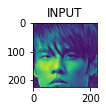

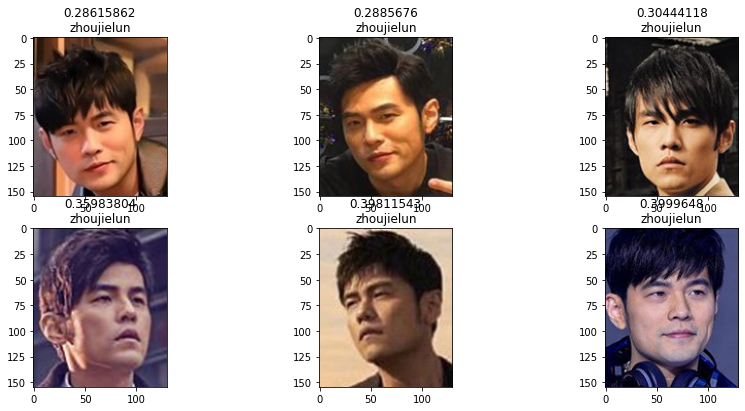

----------


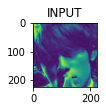

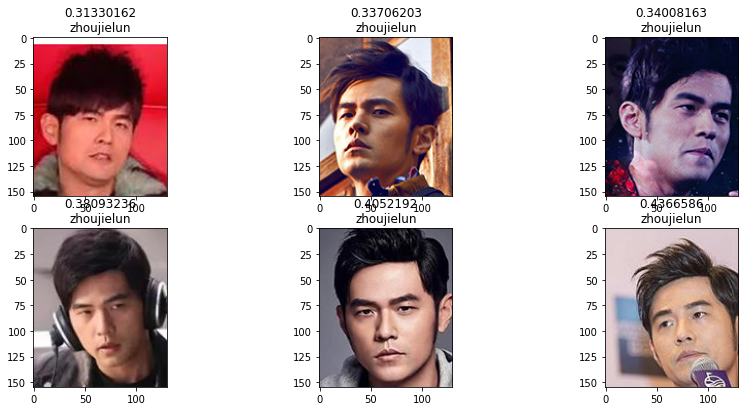

----------


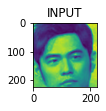

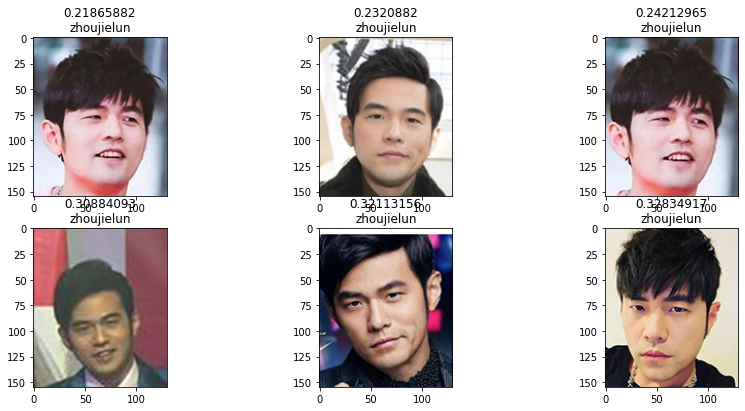

----------


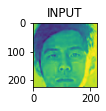

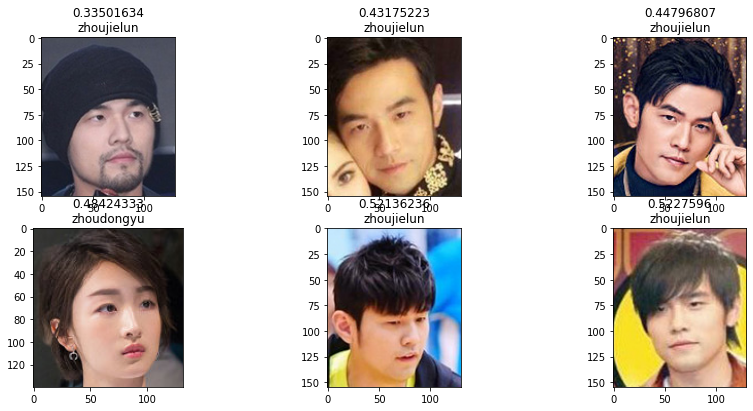

----------


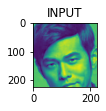

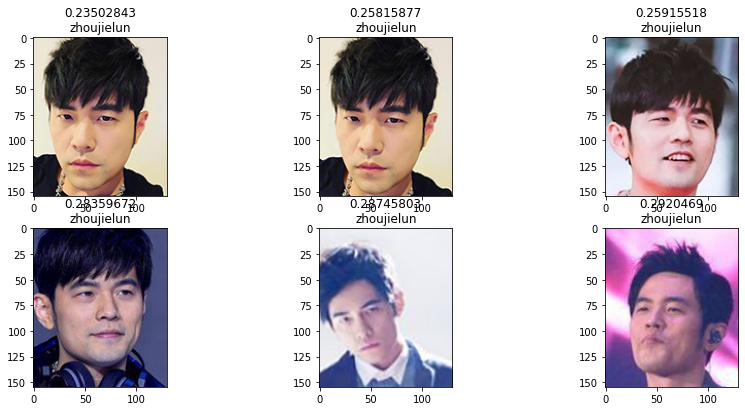

----------


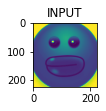

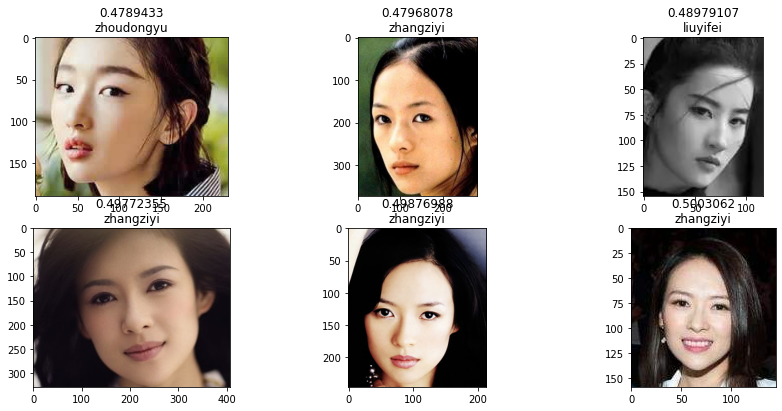

----------


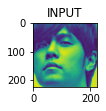

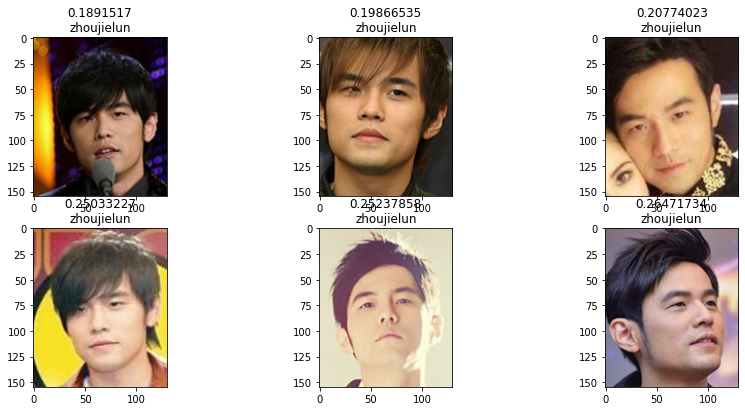

----------


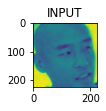

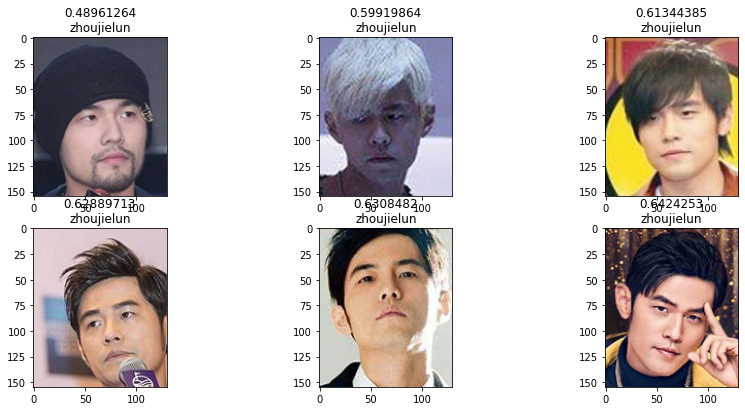

----------


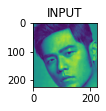

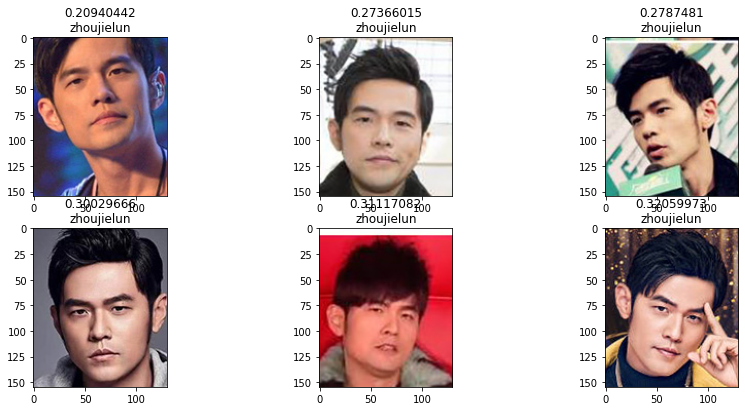

----------


In [0]:
!rm -rf ./test_img/.ipynb_checkpoints
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
# dataset
testdataset = TestDataSets('./test_img/', transform['val'])

for x in data.DataLoader(testdataset):
  x.to(DEVICE)
  out = model(x)
  out.requires_grad=False
  out[0] = out[0] / np.linalg.norm(out[0])
  match_dict = {}
  for y in list(os.listdir("./facetensor")):
    y_tensor = torch.load(os.path.join("./facetensor", y))
    y_tensor.requires_grad = False
    y_tensor = y_tensor / np.linalg.norm(y_tensor)
    dists = np.linalg.norm(y_tensor - out[0])
    match_dict[y] = dists
  sorted_dict = sorted(match_dict.items(), key=lambda x: x[1])[:6]
  
  plt.figure("寻找周杰伦")
  plt.subplots_adjust(wspace = 0.2, hspace = 0.2)
  plt.subplot(3, 3, 1)
  plt.title("INPUT")
  plt.imshow(x[0, -1])
  plt.show()
  i = 4
  for name, probabliity in sorted_dict:
    # 从文件夹中找到
    splited_dir = name.split(".")[0].split("_")
    search_orig_path = os.path.join("./images/face/", splited_dir[0])

    path_file = os.listdir(search_orig_path)
    path_file.sort()
    path_file_image = Image.open(os.path.join(search_orig_path, path_file[int(splited_dir[1])]))
    
    plt.subplots_adjust(top = 2, right = 2)
    plt.subplot(3, 3, i)
    plt.imshow(path_file_image)
    plt.title(str(probabliity) + "\n" + splited_dir[0])
  
    i += 1
    
  plt.show()

  print("-"*10)

### 好，光速退圈

圝◤好，桄速退qυαn◥圝